In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import plotly.express as px

from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import plotly.express as px

from scipy import stats
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

In [6]:
data = pd.read_excel('/Users/ashutoshanand/Documents/UGP- Sanjiv/Dataset and Code files/Onion Processed data.xlsx',index_col='Date')

In [8]:
data

,W.sale Avg.Price,Inflation_rate,Growth_rate,Log_MS,Month,Year,Quarter,Price_1M_Lag,Price_3M_Lag,Inflation_1M_Lag,Price_3M_Rolling_Mean,Price_3M_Rolling_Std,Inflation_Growth_Interaction
Date,,,,,,,,,,,,,
2000-04-01,367.0,5.542171,27.288814,16.261410,4,2000,2,350.0,455.0,4.830924,358.333333,8.504901,151.239272
2000-05-01,369.0,5.011930,38.194843,16.267717,5,2000,2,367.0,358.0,5.542171,362.000000,10.440307,191.429878
2000-06-01,401.0,5.238095,38.171534,16.281510,6,2000,2,369.0,350.0,5.011930,379.000000,19.078784,199.946120
2000-07-01,486.0,4.952828,13.306099,16.281959,7,2000,3,401.0,367.0,5.238095,418.666667,60.467622,65.902813
2000-08-01,460.0,3.990609,22.953398,16.288343,8,2000,3,486.0,369.0,4.952828,449.000000,43.554563,91.598023
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,1834.0,6.998158,-0.679758,19.165064,8,2022,3,1752.0,1271.0,6.707692,1733.666667,110.645078,-4.757056
2022-09-01,1672.0,7.414216,3.320463,19.166083,9,2022,3,1834.0,1615.0,6.998158,1752.666667,81.002058,24.618631
2022-10-01,2290.0,6.767372,-4.074074,19.176894,10,2022,4,1672.0,1752.0,7.414216,1932.000000,320.443443,-27.570773


In [10]:
X = data.drop('W.sale Avg.Price', axis=1)
y = data['W.sale Avg.Price']

# Select top k features
selector = SelectKBest(f_regression, k=5)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features)

Selected features: Index(['Log_MS', 'Year', 'Price_1M_Lag', 'Price_3M_Rolling_Mean',
       'Price_3M_Rolling_Std'],
      dtype='object')


In [30]:
# Prepare data for training
features = X  # or use X[selected_features] if you did feature selection
target = y

# Create time series split for validation
tscv = TimeSeriesSplit(n_splits=5)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, shuffle=False  # No shuffle for time series
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models to try
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate models
for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Find best model
best_model_name = min(results, key=lambda x: results[x]['rmse'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")

# Hyperparameter tuning for best model (example for Random Forest)
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    
    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")


Linear Regression - RMSE: 637.50, MAE: 386.49, R²: 0.83
Ridge Regression - RMSE: 644.01, MAE: 403.12, R²: 0.83
Random Forest - RMSE: 1031.21, MAE: 533.13, R²: 0.55
Gradient Boosting - RMSE: 1009.94, MAE: 477.90, R²: 0.57

Best model: Linear Regression


In [32]:
# After selecting the best model
best_model_name = min(results, key=lambda x: results[x]['rmse'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")

# Hyperparameter tuning code...

# IMPORTANT: Generate predictions using the best model before evaluation
y_pred = best_model.predict(X_test_scaled)

# Now calculate evaluation metrics using predictions from the best model
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)



Best model: Linear Regression


Price Forecast:
        Date  Predicted_Price
0 2023-01-01      2361.913013
1 2023-02-01      2366.185810
2 2023-03-01      2370.458606

Model Evaluation on Test Data:
Mean Squared Error (MSE): 406409.5575
Root Mean Squared Error (RMSE): 637.5026
Mean Absolute Error (MAE): 386.4926
R-squared (R²): 0.8299
Mean Absolute Percentage Error (MAPE): 16.04%


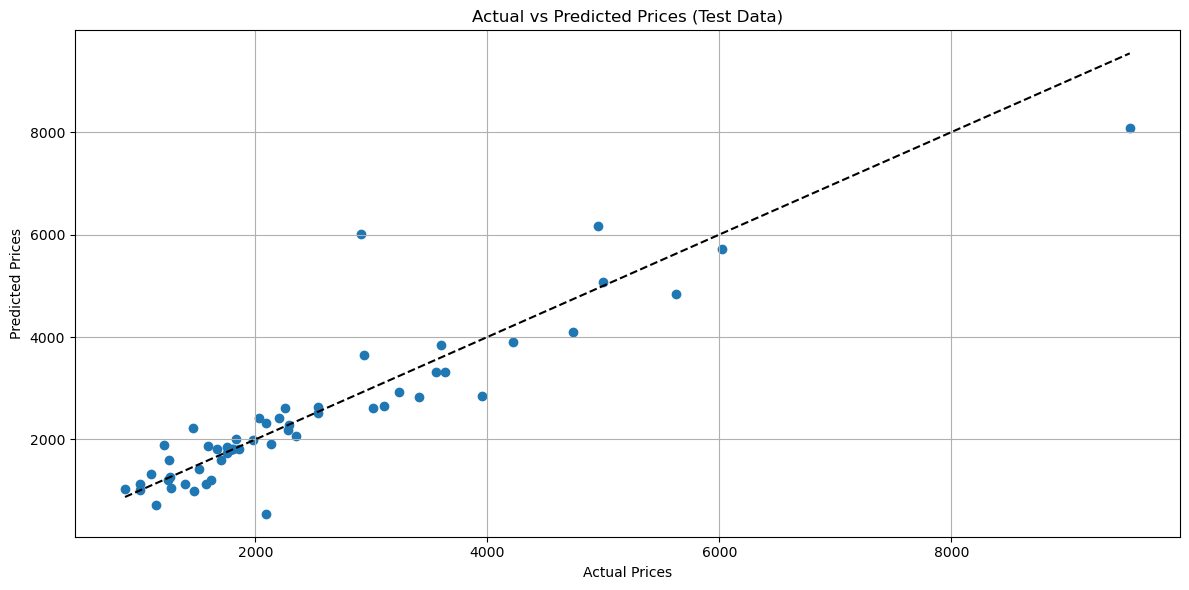

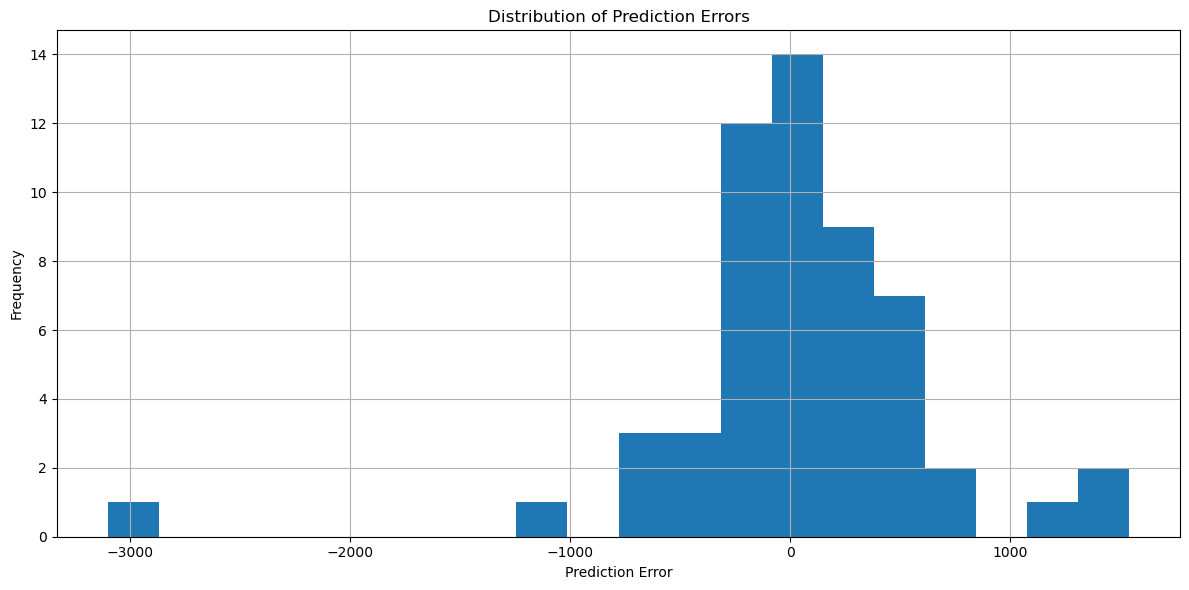

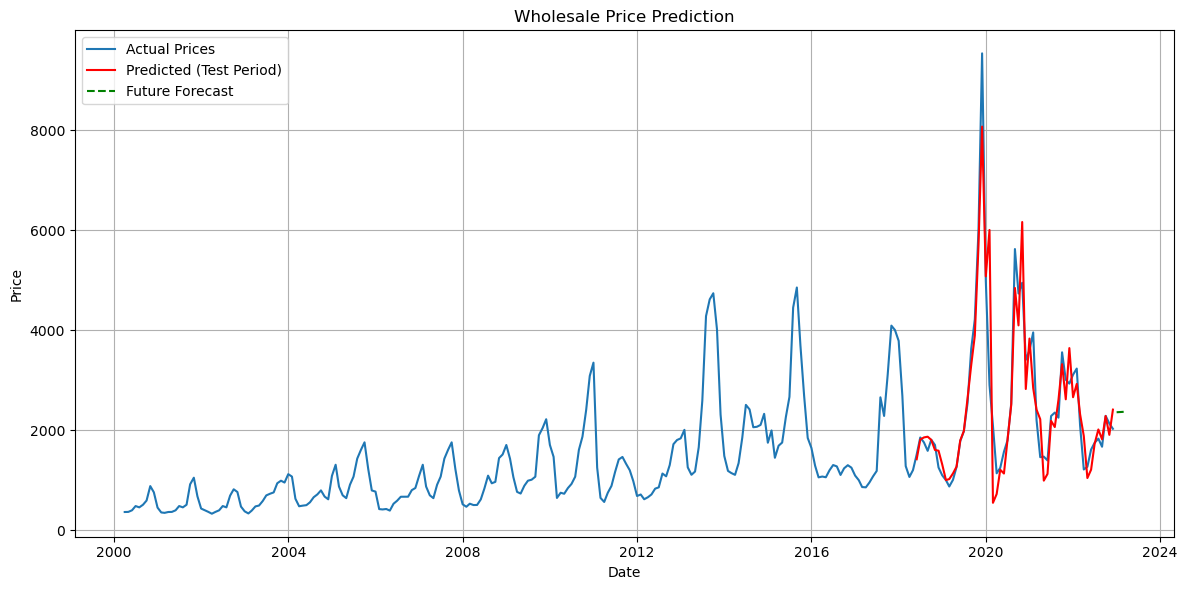

In [34]:
# Function to predict future prices
def predict_prices(model, future_features, scaler):
    """
    Predict prices based on future features
    """
    # Scale features
    future_features_scaled = scaler.transform(future_features)
    
    # Make predictions
    predictions = model.predict(future_features_scaled)
    
    return predictions

# Example: Predict next 3 months
# (In a real scenario, you would need to prepare future_features with actual data)
# This is just a placeholder example assuming you have some future data

# Get the last date in your dataset
last_date = data.index[-1]

# Create some future dates
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=3, freq='MS')

# Create a dummy dataframe with the same features as your training data
# In reality, you would fill this with actual future values for your predictors
future_df = pd.DataFrame(index=future_dates, columns=X.columns)

# Example: Fill with last known values (very simplistic approach)
for col in future_df.columns:
    future_df[col] = X[col].iloc[-1]

# Update temporal features
future_df['Month'] = future_df.index.month
future_df['Year'] = future_df.index.year
future_df['Quarter'] = future_df.index.quarter

# Make predictions
future_predictions = predict_prices(best_model, future_df, scaler)

# Create results dataframe
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions
})

print("Price Forecast:")
print(forecast_df)

# ------------ ADDED MODEL EVALUATION CODE ------------

# 1. Evaluate model performance on test data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics for test predictions
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)  # Root Mean Squared Error
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

# Print evaluation results for test data
print("\nModel Evaluation on Test Data:")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"R-squared (R²): {test_r2:.4f}")

# Calculate MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {test_mape:.2f}%")

# 2. Evaluate model performance on future predictions if actual values become available
# Uncomment and use this code when you have actual future values to compare with predictions
"""
# Assuming future_actual_prices contains actual prices for the forecast period
future_actual_prices = [...]  # Replace with actual future prices when available

future_mse = mean_squared_error(future_actual_prices, future_predictions)
future_rmse = np.sqrt(future_mse)
future_mae = mean_absolute_error(future_actual_prices, future_predictions)
future_r2 = r2_score(future_actual_prices, future_predictions)
future_mape = np.mean(np.abs((future_actual_prices - future_predictions) / future_actual_prices)) * 100

print("\nModel Evaluation on Future Predictions:")
print(f"Mean Squared Error (MSE): {future_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {future_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {future_mae:.4f}")
print(f"R-squared (R²): {future_r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {future_mape:.2f}%")
"""

# 3. Visualize prediction errors on test data
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (Test Data)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Plot error distribution
prediction_errors = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.hist(prediction_errors, bins=20)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------ ORIGINAL VISUALIZATION CODE ------------

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['W.sale Avg.Price'], label='Actual Prices')
plt.plot(X_test.index, y_pred, color='red', label='Predicted (Test Period)')
plt.plot(forecast_df['Date'], forecast_df['Predicted_Price'], 'g--', label='Future Forecast')
plt.title('Wholesale Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Linear Regression Performance Metrics:
MSE: 1019975.45
RMSE: 1009.94
MAE: 477.90
MAPE: 15.44%
R²: 0.5731
Adjusted R²: 0.4511


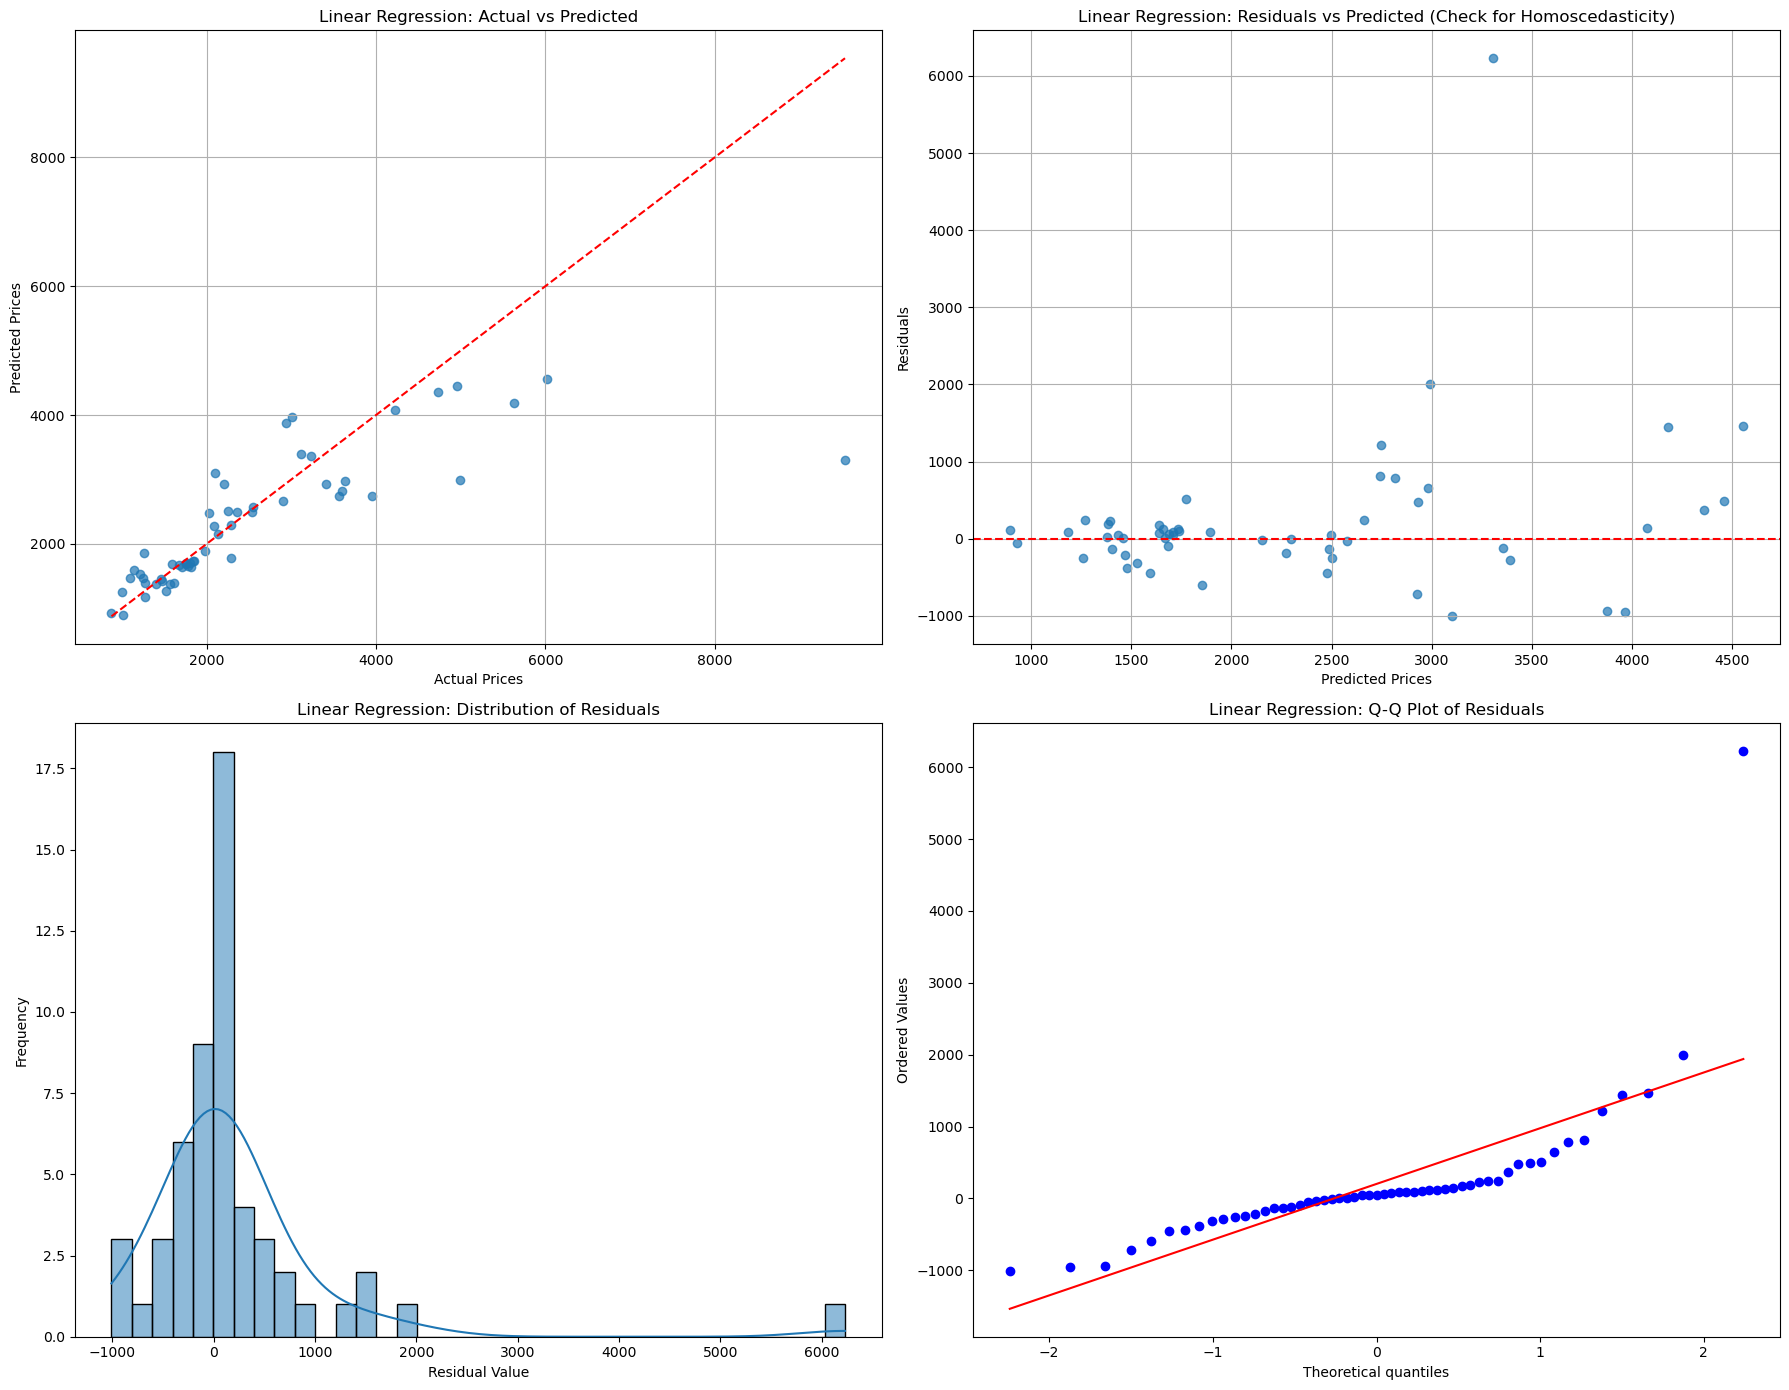

{'mse': 1019975.4486586287,
 'rmse': 1009.9383390378982,
 'mae': 477.9007872310362,
 'mape': 15.443447354729681,
 'r2': 0.5731069725175731,
 'adjusted_r2': 0.45113753609402263}

In [22]:
evaluate_linear_regression(X_train, X_test, y_train, y_test, y_pred, model, model_name="Linear Regression")